## Identifying Latent Return Drivers Using Principal Component Analysis

In [2]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from openbb import obb
from sklearn.decomposition import PCA

In [4]:
obb.user.preferences.output_type = "dataframe"

Define the symbols for gold and healthcare stocks

In [5]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK", "GOOG", "META"]

Fetch historical price data for the defined symbols from 2020-01-01 to 2022-12-31 using the "yfinance" provider

In [6]:
data = obb.equity.price.historical(
    symbols,
    start_date="2020-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

In [7]:
display(data)

symbol,CDE,GOOG,JNJ,LLY,META,MRK,NEM,RGLD,SSRM,UNH
date,,,,,,,,,,
2020-01-02,7.81,68.368500,145.970001,132.210007,209.779999,87.824425,43.220001,121.120003,18.969999,292.500000
2020-01-03,7.70,68.032997,144.279999,131.770004,208.669998,87.070610,42.830002,120.129997,18.520000,289.540009
2020-01-06,6.93,69.710503,144.100006,132.259995,212.600006,87.442749,43.259998,118.809998,18.370001,291.549988
2020-01-07,6.89,69.667000,144.979996,132.509995,213.059998,85.114502,43.230000,120.180000,18.660000,289.790009
2020-01-08,6.29,70.216003,144.960007,133.710007,215.220001,84.541985,42.080002,111.599998,18.219999,295.899994
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,3.43,89.809998,177.479996,367.899994,118.040001,111.860001,47.849998,112.839996,15.950000,531.309998
2022-12-27,3.69,87.930000,177.429993,364.880005,116.879997,112.120003,48.750000,114.410004,16.340000,531.989990
2022-12-28,3.47,86.459999,176.660004,365.220001,115.620003,111.080002,47.369999,111.500000,15.700000,528.450012


Calculate the daily percentage returns and drop any missing values

In [8]:
returns = data.pct_change().dropna()

Initialize PCA with 3 components and fit it to the returns data

In [9]:
pca = PCA(n_components=3)
pca.fit(returns)

PCA(n_components=3)

Get the explained variance ratio and the principal components

In [10]:
pct = pca.explained_variance_ratio_
pca_components = pca.components_

In [11]:
display(pca_components)

array([[ 0.76313486,  0.14156698,  0.06849232,  0.07348687,  0.17089027,
         0.07402392,  0.2815211 ,  0.29834792,  0.41381856,  0.11531703],
       [-0.16500682,  0.42870763,  0.19515701,  0.33340339,  0.65433028,
         0.21236665, -0.1128354 , -0.12039768, -0.1709495 ,  0.33172213],
       [ 0.59440458, -0.06604594,  0.04055722,  0.13575167, -0.2281739 ,
         0.09790658, -0.35835604, -0.39849502, -0.51746185,  0.07493064]])

Plot the contribution and cumulative contribution of the principal components

In [12]:
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct) + 1, 1)

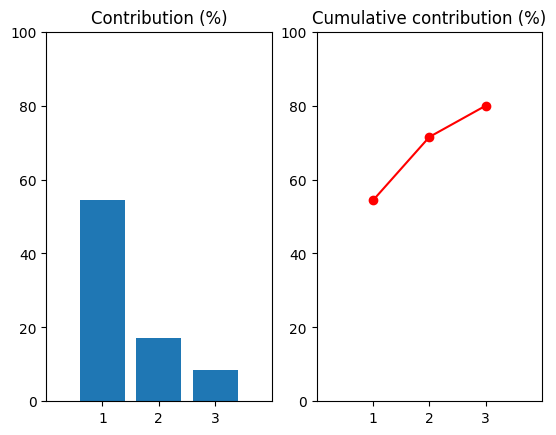

In [13]:
plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, "ro-")
plt.title("Cumulative contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.show()

Construct "statistical risk factors" from the principal components

In [14]:
X = np.asarray(returns)
factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"], index=returns.index, data=factor_returns
)

In [15]:
display(factor_returns)

,f1,f2,f3
date,,,
2020-01-03,-0.029983,-0.005733,0.009405
2020-01-06,-0.072103,0.045176,-0.059001
2020-01-07,0.003544,-0.007743,-0.018954
2020-01-08,-0.099565,0.048567,-0.002267
2020-01-09,0.006181,0.022470,0.024871
...,...,...,...
2022-12-23,0.005604,0.017794,-0.018559
2022-12-27,0.072466,-0.037763,0.022942
2022-12-28,-0.083156,0.003856,0.007217


Calculate the factor exposures

In [16]:
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"], columns=returns.columns, data=pca_components
).T

In [17]:
display(factor_exposures)

,f1,f2,f3
symbol,,,
CDE,0.763135,-0.165007,0.594405
GOOG,0.141567,0.428708,-0.066046
JNJ,0.068492,0.195157,0.040557
LLY,0.073487,0.333403,0.135752
META,0.170890,0.654330,-0.228174
MRK,0.074024,0.212367,0.097907
NEM,0.281521,-0.112835,-0.358356
RGLD,0.298348,-0.120398,-0.398495
SSRM,0.413819,-0.170949,-0.517462


Plot the factor exposure of the first principal component

<Axes: xlabel='symbol'>

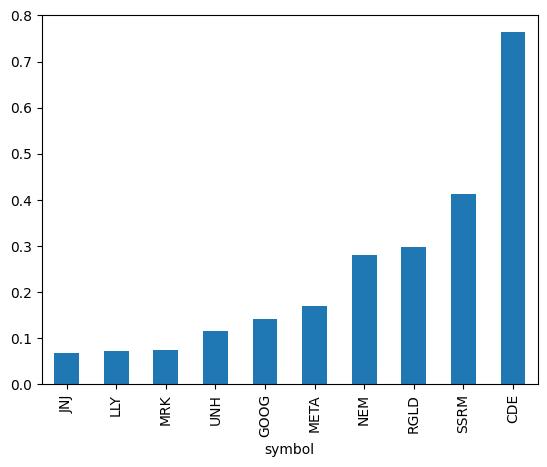

In [18]:
factor_exposures.f1.sort_values().plot.bar()

Scatter plot of the factor exposures of the first two principal components

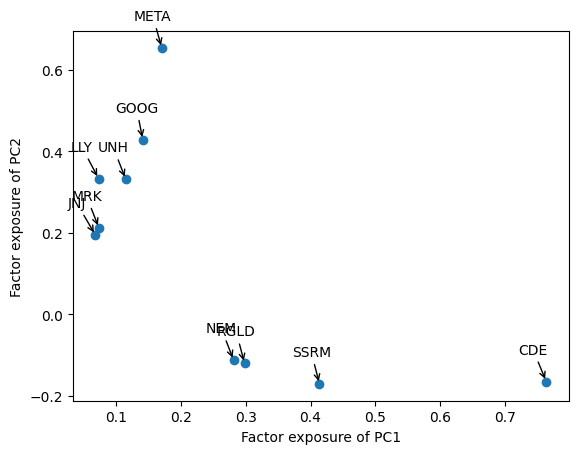

In [19]:
labels = factor_exposures.index
data = factor_exposures.values
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel("Factor exposure of PC1")
plt.ylabel("Factor exposure of PC2")

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(-20, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
    )

plt.show()

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.